This is a Python Notebook to do Machine Learning with only sklearn and xgboost. There is no EDA or Visualization.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.drop(columns=['customerID'], inplace=True)

In [5]:
cat_names = df.select_dtypes(include=['object']).columns.tolist()
num_names = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [6]:
cat_names.remove('Churn')  # Remove target variable from categorical features

In [7]:
print(cat_names)
print(num_names)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.2, random_state=42,stratify=df['Churn'])

In [9]:
print("Percentage of churn in training set:", y_train.value_counts(normalize=True) * 100)
print("Percentage of churn in test set:", y_test.value_counts(normalize=True) * 100)

Percentage of churn in training set: Churn
No     73.464679
Yes    26.535321
Name: proportion, dtype: float64
Percentage of churn in test set: Churn
No     73.456352
Yes    26.543648
Name: proportion, dtype: float64


In [10]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

Accuracy: 0.7622427253371186
F1 Score: 0.524822695035461
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1035
           1       0.56      0.49      0.52       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.75      0.76      0.76      1409

Confusion Matrix:
 [[889 146]
 [189 185]]


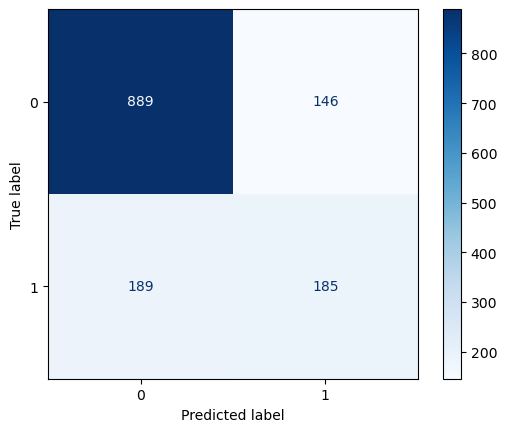

In [11]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_names),
        ('num', num_transformer, num_names)])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, pos_label=1))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__scale_pos_weight': 2}
Best Model Accuracy: 0.7806955287437899
Best Model F1 Score: 0.641946697566628
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1035
           1       0.57      0.74      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



<Figure size 1000x600 with 0 Axes>

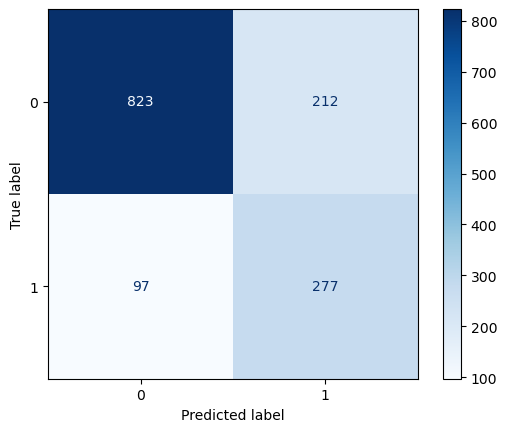

In [ ]:
# Hyperparameter tuning using GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__scale_pos_weight': [1, 2, 3],  # Adjusting for class imbalance
}

grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1,random_state=42)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model F1 Score:", f1_score(y_test, y_pred_best, pos_label=1))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

Best parameters found:  OrderedDict({'model__colsample_bytree': 0.7430746767123384, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 296, 'model__scale_pos_weight': 2, 'model__subsample': 0.5})
Best Model Accuracy: 0.7792760823278921
Best Model F1 Score: 0.6396292004634995
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      1035
           1       0.56      0.74      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



<Figure size 1000x600 with 0 Axes>

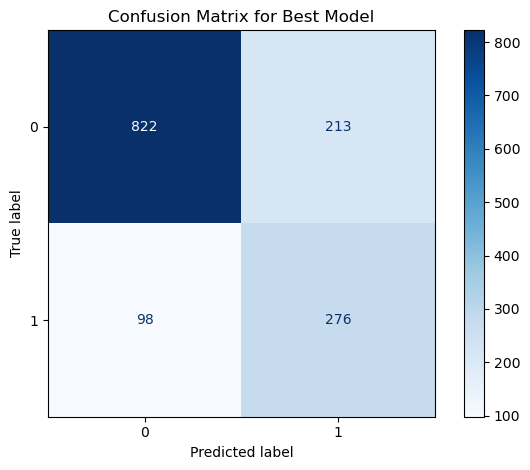

In [28]:
from skopt import BayesSearchCV

param_grid_2 = {
    'model__n_estimators': (100,500),
    'model__max_depth': (3,10),
    'model__learning_rate': (.01,.1,'log-uniform'),
    'model__scale_pos_weight': (1, 3),  # Adjusting for class imbalance
    'model__subsample': (.5,1),
    'model__colsample_bytree': (.6,1),
}

grid_search_2 = BayesSearchCV(clf, search_spaces=param_grid_2, scoring='f1', cv=3, n_jobs=-1,random_state=42)
grid_search_2.fit(X_train, y_train)

print("Best parameters found: ", grid_search_2.best_params_)
best_model_2 = grid_search_2.best_estimator_
y_pred_best_2 = best_model_2.predict(X_test)

print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best_2))
print("Best Model F1 Score:", f1_score(y_test, y_pred_best_2, pos_label=1))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best_2))
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_estimator(best_model_2, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found with SMOTE:  {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 300, 'smote__k_neighbors': 7}
Best F1:  0.6364733645516619
Best Model with SMOTE Accuracy: 0.7835344215755855
Best Model with SMOTE F1 Score: 0.6257668711656442
Best Model with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1035
           1       0.58      0.68      0.63       374

    accuracy                           0.78      1409
   macro avg       0.73      0.75      0.74      1409
weighted avg       0.80      0.78      0.79      1409



<Figure size 1000x600 with 0 Axes>

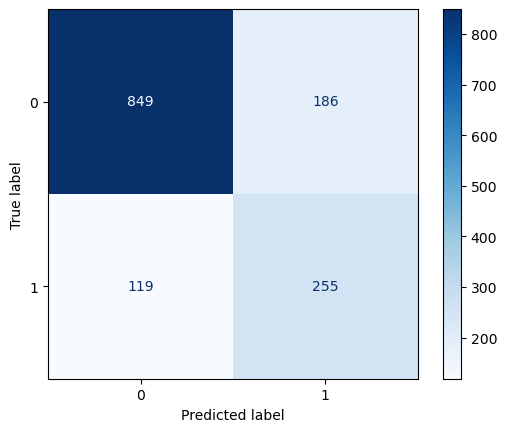

In [ ]:
#using SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote = SMOTE(random_state=42, k_neighbors=5)
imb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', XGBClassifier(random_state=42))
])

param_grid_imb = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'smote__k_neighbors': [3, 5, 7],  # Adjusting for SMOTE neighbors
}

grid_search_imb = GridSearchCV(imb_pipeline, param_grid=param_grid_imb, scoring='f1', cv=3, verbose=1, n_jobs=-1,random_state=42)
grid_search_imb.fit(X_train, y_train)

best_model_imb = grid_search_imb.best_estimator_
y_pred_best_imb = best_model_imb.predict(X_test)

print("Best parameters found with SMOTE: ", grid_search_imb.best_params_)
print("Best F1: ", grid_search_imb.best_score_)
print("Best Model with SMOTE Accuracy:", accuracy_score(y_test, y_pred_best_imb))
print("Best Model with SMOTE F1 Score:", f1_score(y_test, y_pred_best_imb, pos_label=1))
print("Best Model with SMOTE Classification Report:\n", classification_report(y_test, y_pred_best_imb))
plt.figure(figsize=(10, 6))
ConfusionMatrixDisplay.from_estimator(best_model_imb, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

None of the hyperparameter tuning is making model improvements anymore. So we probably need feature engineering or bring in more data.

In [29]:
import joblib
joblib.dump(best_model_2, 'best_xgb_model.joblib')

['best_xgb_model.joblib']